# Question 1

In [5]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint
import urllib.request
import random

In [6]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = urllib.request.urlopen(url)
shakespeare_text = response.read().decode("utf-8")
words = shakespeare_text.split('\n\n',800)[:-1]

URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:992)>

In [ ]:
# Assuming words is your list
random.shuffle(words)

In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set('\n\n'.join(words))))
stoi = {s:i for i,s in enumerate(chars)}
itos = {i:s for s,i in stoi.items()}
pprint(itos)

{0: '\n',
 1: ' ',
 2: '!',
 3: '&',
 4: "'",
 5: ',',
 6: '-',
 7: '.',
 8: ':',
 9: ';',
 10: '?',
 11: 'A',
 12: 'B',
 13: 'C',
 14: 'D',
 15: 'E',
 16: 'F',
 17: 'G',
 18: 'H',
 19: 'I',
 20: 'J',
 21: 'K',
 22: 'L',
 23: 'M',
 24: 'N',
 25: 'O',
 26: 'P',
 27: 'Q',
 28: 'R',
 29: 'S',
 30: 'T',
 31: 'U',
 32: 'V',
 33: 'W',
 34: 'Y',
 35: 'a',
 36: 'b',
 37: 'c',
 38: 'd',
 39: 'e',
 40: 'f',
 41: 'g',
 42: 'h',
 43: 'i',
 44: 'j',
 45: 'k',
 46: 'l',
 47: 'm',
 48: 'n',
 49: 'o',
 50: 'p',
 51: 'q',
 52: 'r',
 53: 's',
 54: 't',
 55: 'u',
 56: 'v',
 57: 'w',
 58: 'x',
 59: 'y',
 60: 'z'}


In [ ]:
block_size = 5 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:]:
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
#     print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
# Move data to GPU
# print(X)
# print(Y)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

In [ ]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([105394, 5]), torch.int64, torch.Size([105394]), torch.int64)

In [ ]:
# Embedding layer for the context

emb_dim = 4
emb = torch.nn.Embedding(len(stoi), emb_dim)

In [ ]:
emb.weight

Parameter containing:
tensor([[ 1.4805e-01, -8.0905e-02, -1.3787e+00, -5.0340e-01],
        [ 5.0123e-01, -1.2820e+00,  4.7697e-01,  9.0788e-01],
        [ 7.4087e-01, -3.8500e-01,  1.7074e+00,  1.7006e+00],
        [ 5.4809e-01,  1.6331e+00,  8.6395e-01, -1.0226e+00],
        [-3.7570e-01, -1.2175e+00, -1.2157e-02, -5.2612e-01],
        [-1.0874e+00,  9.9152e-01,  1.7973e+00,  6.9538e-01],
        [-4.3532e-01, -6.1824e-01,  2.2399e-01,  1.0916e+00],
        [-5.3376e-01, -1.1941e+00,  2.5059e-02, -7.8944e-01],
        [ 8.7436e-01, -1.4575e+00,  1.9555e+00,  1.2243e-01],
        [-7.7725e-02,  4.9743e-01,  1.0409e+00,  9.1882e-01],
        [ 9.9608e-01, -2.4626e-01,  4.3222e-01,  6.6763e-01],
        [ 1.7136e+00,  1.2192e+00, -1.4371e-01,  1.0230e+00],
        [ 6.8014e-01, -7.3670e-01,  1.7200e-01,  7.3856e-03],
        [-2.1350e-01, -4.5504e-01,  6.4579e-01, -1.6631e+00],
        [ 6.9308e-03,  2.5430e-01, -6.6581e-01,  1.4906e-01],
        [-1.4825e+00, -7.4065e-01,  7.5154e-01, 

In [ ]:
emb.weight.shape

torch.Size([61, 4])

<Axes: >

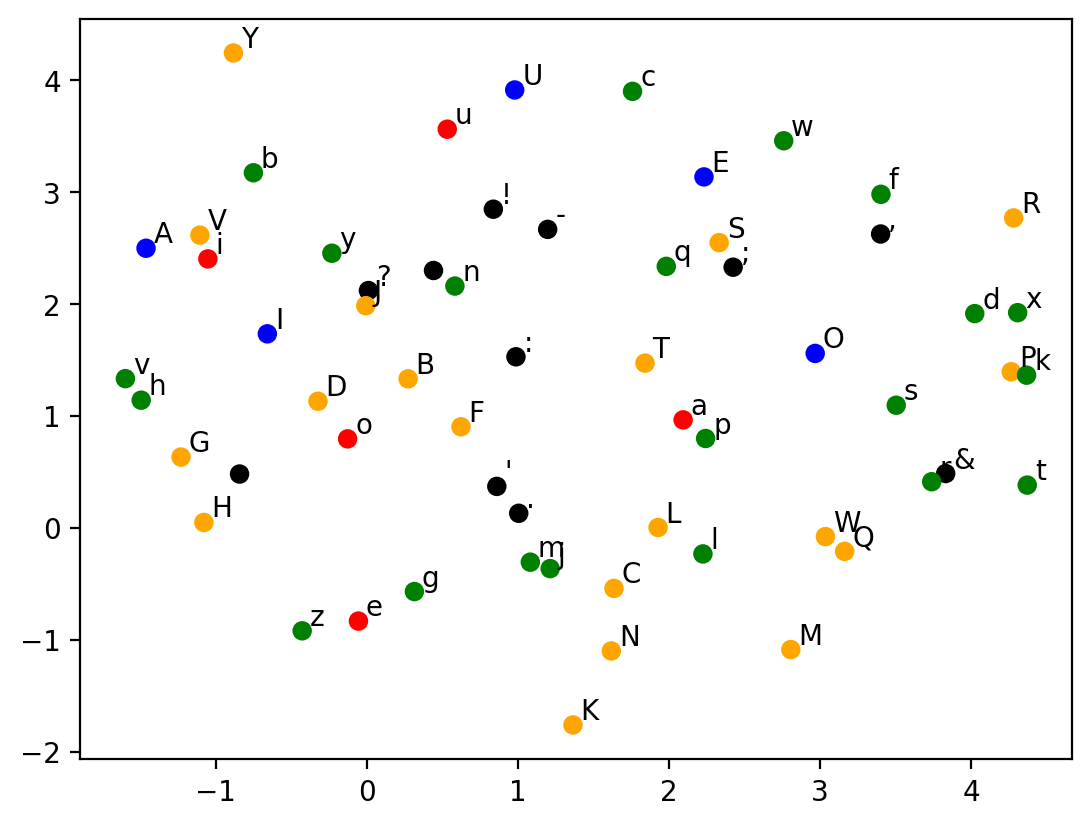

In [ ]:
from sklearn.manifold import TSNE

def plot_emb_2d(emb, itos, ax=None):
    # Compute t-SNE transformation
    tsne = TSNE(n_components=2)
    emb_2d = tsne.fit_transform(emb.weight.cpu().detach().numpy())

    # Precompute color mapping
    color_mapping = {char: 'r' for char in 'aeiou'}
    color_mapping.update({char: 'b' for char in 'AEIOU'})
    color_mapping.update({char: 'g' for char in 'bcdfghjklmnpqrstvwxyz'})
    color_mapping.update({char: 'orange' for char in 'bcdfghjklmnpqrstvwxyz'.upper()})
    color_mapping = {char: color_mapping.get(char, 'k') for char in itos.values()}

    if ax is None:
        fig, ax = plt.subplots()

    # Create lists for x and y coordinates and colors
    xs, ys, colors = [], [], []
    for i in range(len(itos)):
        x, y = emb_2d[i]
        xs.append(x)
        ys.append(y)
        colors.append(color_mapping[itos[i]])

    # Plot all points at once
    ax.scatter(xs, ys, color=colors)

    # Add labels
    for i in range(len(itos)):
        ax.text(xs[i] + 0.05, ys[i] + 0.05, itos[i])

    return ax

plot_emb_2d(emb, itos)


In [ ]:
class NextChar(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size, num_layers):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lins = nn.ModuleList([nn.Linear((block_size * emb_dim if i == 0 else hidden_size), hidden_size) for i in range(num_layers)])
        self.lin_out = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)
        for lin in self.lins:
            x = torch.relu(lin(x))
        x = self.lin_out(x)
        return x


In [ ]:
# Generate names from untrained model
# Set TORCH_LOGS and TORCHDYNAMO_VERBOSE
import os
os.environ["TORCH_LOGS"] = "+dynamo"
os.environ["TORCHDYNAMO_VERBOSE"] = "1"

# Suppress errors and fallback to eager execution
import torch._dynamo
torch._dynamo.config.suppress_errors = True
# Generate names from untrained model

model = NextChar(block_size, len(stoi), emb_dim, 512, 3).to(device)
model = torch.compile(model)

g = torch.Generator()
g.manual_seed(4000002)
def generate_name(model, itos, stoi, block_size, input_text = "", max_len=100):
    context = [0] * block_size
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        ch = itos[ix]
#         if ch == '.':
#             break
        input_text += ch
        context = context[1:] + [ix]
    return input_text

In [ ]:
print(generate_name(model, itos, stoi, block_size, input_text = "Hello", max_len = 200))

HellovphlJ,TG'k,Ls;C-h.MYgFHVE;FTctN
?wiwvgcWN!yqOD:-,yj:Tja&S.rykdoS.RNdgoz&.IBpVBexyEW!xzKOFcGExFQGs.ghaI:uQT'.kJRzHn?VY
vrcczhU&WF:iWzd.LbOMEJwHfwrwiOp. fG'THQfqGMKILFUmIjpJhMz
' Kb.te
l-inuxPgHAYMeQRTJ


In [ ]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

_orig_mod.emb.weight torch.Size([61, 4])
_orig_mod.lins.0.weight torch.Size([512, 20])
_orig_mod.lins.0.bias torch.Size([512])
_orig_mod.lins.1.weight torch.Size([512, 512])
_orig_mod.lins.1.bias torch.Size([512])
_orig_mod.lins.2.weight torch.Size([512, 512])
_orig_mod.lins.2.bias torch.Size([512])
_orig_mod.lin_out.weight torch.Size([61, 512])
_orig_mod.lin_out.bias torch.Size([61])


In [ ]:
# Train the model

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.001)
import time
# Mini-batch training
batch_size = 4096
print_every = 100
elapsed_time = []
for epoch in range(1000):
    start_time = time.time()
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
    end_time = time.time()
    elapsed_time.append(end_time - start_time)
    if epoch % print_every == 0:
        print(epoch, loss.item())

0 0.7438047528266907
100 0.6789857149124146
200 0.6907629370689392
300 0.6822497844696045
400 0.6664901971817017
500 0.669177770614624
600 0.6513917446136475
700 0.6518481969833374
800 0.656704306602478
900 0.656230628490448


<Axes: >

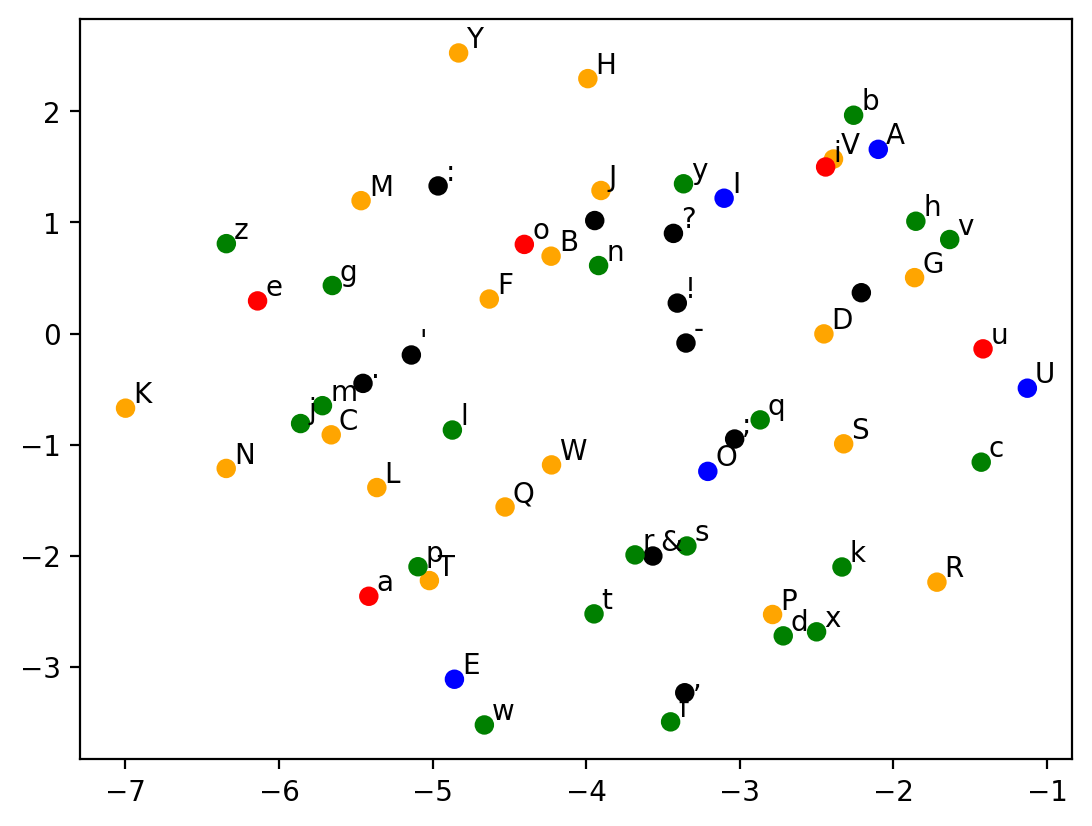

In [ ]:
plot_emb_2d(emb, itos)

In [ ]:
print(generate_name(model, itos, stoi, block_size, input_text = "and it ended.\n", max_len = 1000))

and it ended.
MARCIUS:
Thither tribunes, ho!'
'Sicinius!' 'Coriolanus must I wish have chosen tribunes of rught.. Could he had may gell us human power, and take the tongues: there, aad nature,
With our own you lessed her in no way in some all..'lder? would with most of no many thanks. What!
This is not with great Aufidius, we may march from you were word, therefore, be chose a consul? By you..ay poor it...would grind it...uckAimy censured,
No impediments and pluck Aufidius, we'll prompt than a rod to many service?.
Masters, if we within their voice: the peace Speak, goodly city articulate hath yet sought it, but done...uBtunothing once may gentry think we have your loved this pasture leave me grievest house my way the great you have your honour
Than that want make my audit up, have plain,
In people and that not to think
Rather had to his eyely transport: as his bisson mouthsy with dying him joyful to 't...wour election...would than a little and is cannot can a think
'Tis warning: thy t

# Streamlit app implementation

In [ ]:
%%writefile app.py
import streamlit as st
import torch
import torch.nn.functional as F
from torch import nn
import urllib.request
import random
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = urllib.request.urlopen(url)
shakespeare_text = response.read().decode("utf-8")
words = shakespeare_text.split('\n\n',800)[:-1]
random.shuffle(words)
chars = sorted(list(set('\n\n'.join(words))))
stoi = {s:i for i,s in enumerate(chars)}
itos = {i:s for s,i in stoi.items()}
block_size = 5 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:]:
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
#     print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)
emb_dim = 4
emb = torch.nn.Embedding(len(stoi), emb_dim)
class NextChar(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size, num_layers):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lins = nn.ModuleList([nn.Linear((block_size * emb_dim if i == 0 else hidden_size), hidden_size) for i in range(num_layers)])
        self.lin_out = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)
        for lin in self.lins:
            x = torch.relu(lin(x))
        x = self.lin_out(x)
        return x
import os
os.environ["TORCH_LOGS"] = "+dynamo"
os.environ["TORCHDYNAMO_VERBOSE"] = "1"

# Suppress errors and fallback to eager execution
import torch._dynamo
torch._dynamo.config.suppress_errors = True
# Generate names from untrained model

model = NextChar(block_size, len(stoi), emb_dim, 512, 3).to(device)
model = torch.compile(model)

g = torch.Generator()
g.manual_seed(4000002)
def generate_name(model, itos, stoi, block_size, input_text = "", max_len=100):
    context = [0] * block_size
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        ch = itos[ix]
#         if ch == '.':
#             break
        input_text += ch
        context = context[1:] + [ix]
    return input_text

# Create a sidebar for user inputs
st.sidebar.title('Parameters')
input_text = st.sidebar.text_input('Input Text', 'and it ended.\n')
max_len = st.sidebar.slider('Max Length', 1, 1000, 100)
num_layers = st.sidebar.slider('Number of Layers', 1, 10, 3)

# When the 'Generate' button is clicked, call the function with the user's inputs
if st.sidebar.button('Generate'):
    model = NextChar(block_size, len(stoi), emb_dim, 512, num_layers).to(device)
    model = torch.compile(model)
    g = torch.Generator()
    g.manual_seed(4000002)
    loss_fn = nn.CrossEntropyLoss()
    opt = torch.optim.AdamW(model.parameters(), lr=0.001)
    # Mini-batch training
    batch_size = 4096
    print_every = 100
    elapsed_time = []
    for epoch in range(500):
        for i in range(0, X.shape[0], batch_size):
            x = X[i:i+batch_size]
            y = Y[i:i+batch_size]
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            loss.backward()
            opt.step()
            opt.zero_grad()    
    
    output_text = generate_name(model, itos, stoi, block_size, input_text, max_len)
    st.write(output_text)


Overwriting app.py


In [ ]:
! wget -q -O - ipv4.icanhazip.com

34.70.18.234


In [ ]:
! streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Network URL: http://172.19.2.2:8501
  External URL: http://34.70.18.234:8501

your url is: https://loud-sloths-run.loca.lt
[2024-03-20 22:56:31,765] torch._dynamo.eval_frame: [DEBUG] skipping __init__ /opt/conda/lib/python3.10/contextlib.py
[2024-03-20 22:56:31,765] torch._dynamo.eval_frame: [DEBUG] skipping __enter__ /opt/conda/lib/python3.10/contextlib.py
[2024-03-20 22:56:31,765] torch._dynamo.eval_frame: [DEBUG] skipping helper /opt/conda/lib/python3.10/contextlib.py
[2024-03-20 22:56:31,765] torch._dynamo.eval_frame: [DEBUG] skipping __init__ /opt/conda/lib/python3.10/contextlib.py
[2024-03-20 22:56:31,765] torch._dynamo.eval_frame: [DEBUG] skipping __enter__ /opt/conda/lib/python3.10/contextlib.py
[2024-03-20 22:56:31,765] torch._dynamo.eval_frame: [DEBUG] skipping enable_dynamic /opt/conda/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py
[2024-03-20 22:56:31,766] torch._dynamo.eval_frame: [DEBUG] skipping _wrap